<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [ ]:
!pip install catboost
!pip install pytorch-transformers
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
#from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score,make_scorer,accuracy_score
from sklearn.svm import SVC,LinearSVC

from catboost import Pool, CatBoostClassifier



from tqdm import notebook,tqdm, trange
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.dummy import DummyClassifier
import lightgbm
 
nltk.download('wordnet','stopwords','punkt','averaged_perceptron_tagger')
from nltk.corpus import wordnet

import time 
 
import warnings
warnings.filterwarnings('ignore')


from sklearn.base import BaseEstimator, TransformerMixin
from gensim.models import Word2Vec
from sklearn.pipeline import Pipeline

from pytorch_transformers import BertTokenizer, BertConfig,AdamW, BertForSequenceClassification

from IPython.display import clear_output
import matplotlib.pyplot as plt
import io

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
#from keras.preprocessing.sequence import pad_sequences

from keras.utils import pad_sequences


In [ ]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
try:
    comments = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/toxic_comments.csv')
except:
    comments = pd.read_csv('/datasets/toxic_comments.csv')

In [ ]:
comments.head(10)

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
5,5,"""\n\nCongratulations from me as well, use the ...",0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,Your vandalism to the Matt Shirvington article...,0
8,8,Sorry if the word 'nonsense' was offensive to ...,0
9,9,alignment on this subject and which are contra...,0


In [ ]:
comments.toxic.value_counts()/comments.shape[0]*100

0    89.838787
1    10.161213
Name: toxic, dtype: float64

In [ ]:
def df_info(df): 
  df.info()
  print(80*"+")
  print(f'количество пропусков по столбцам:')
  for i,j in enumerate(df.columns):
    print(j,'=',df.iloc[:,i].isnull().sum())
  print('Описание количественных переменных:')
  print(df.describe(percentiles=[.25,.5]))
  print(80*"+")
  print(f'количество дубликатов в таблице = {df.duplicated().sum()}')

In [ ]:
df_info(comments)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
количество пропусков по столбцам:
Unnamed: 0 = 0
text = 0
toxic = 0
Описание количественных переменных:
          Unnamed: 0          toxic
count  159292.000000  159292.000000
mean    79725.697242       0.101612
std     46028.837471       0.302139
min         0.000000       0.000000
25%     39872.750000       0.000000
50%     79721.500000       0.000000
max    159450.000000       1.000000
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
количество дубликатов в таблице = 0


In [ ]:
comments['text'] = comments['text'].values.astype('U')

In [ ]:
comments['text'] = comments['text'].str.lower()

In [ ]:

comments_new = []
pattern = r'[^a-zA-Z0-9]' #r'[^a-zA-z]' [^a-zA-Z0-9]
for sentence in comments.text:
  cleared_text = re.sub(pattern, " ", sentence)
  comments_new.append(" ". join(cleared_text.split()))

In [ ]:
comments["clear_text"]=comments_new
comments.head()

,Unnamed: 0,text,toxic,clear_text
0,0,explanation\nwhy the edits made under my usern...,0,explanation why the edits made under my userna...
1,1,d'aww! he matches this background colour i'm s...,0,d aww he matches this background colour i m se...
2,2,"hey man, i'm really not trying to edit war. it...",0,hey man i m really not trying to edit war it s...
3,3,"""\nmore\ni can't make any real suggestions on ...",0,more i can t make any real suggestions on impr...
4,4,"you, sir, are my hero. any chance you remember...",0,you sir are my hero any chance you remember wh...


In [ ]:
sample_size = 20000
corpus = comments.sample(n=sample_size,random_state=0).reset_index(drop=True)
print('соотношение классов в датасете corpus\n', corpus.toxic.value_counts()/corpus.shape[0]*100)

соотношение классов в датасете corpus
 0    90.02
1     9.98
Name: toxic, dtype: float64


In [ ]:
corpus.head()

,Unnamed: 0,text,toxic,clear_text
0,33743,"""\nwell, since i am blocked, i shall temporari...",0,well since i am blocked i shall temporarily re...
1,86756,"""\n\nhahahahaha. typical. \n\nthe article is a...",0,hahahahaha typical the article is about anti p...
2,47612,which you made after i was encouraged by a med...,0,which you made after i was encouraged by a med...
3,96993,i regard you a racist. i will request you be b...,1,i regard you a racist i will request you be ba...
4,66309,"""\n\na broken chair is not a chair\na broken c...",0,a broken chair is not a chair a broken chord i...


In [ ]:
# инициализация Wordnet Lemmatizer
L = WordNetLemmatizer()

In [ ]:
def lemmatizered(corpus):
  ''' функция выполняет токенизациию и лемматизацию массива текстов'''
  corpus_new = []
  for sentence in corpus:
    word_list = nltk.word_tokenize(sentence)
    corpus_new.append(' '.join([L.lemmatize(w) for w in word_list]))
  return corpus_new

In [ ]:

nltk.download('stopwords')
stopwords.words('english')[:5]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['i', 'me', 'my', 'myself', 'we']

In [ ]:
def get_wordnet_pos(word):
    """функция возвращает словарь, где возвращается значение часть речи (pos_tag)"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
 
    return tag_dict.get(tag, wordnet.NOUN)

In [ ]:
def get_word_text(corpus):
  ''' функция выполняет токенизациию и лемматизацию массива текстов c учетом pos_tag и удаление стоп-слов'''
  corpus_new = []
  for sentence in corpus:
    corpus_new.append(' '.join([L.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(sentence) if not w in stopwords.words('english')]))
  return corpus_new

In [ ]:
 %%time
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
 
corpus['lemma_text_no_sw'] = get_word_text(corpus['clear_text'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


CPU times: user 3min 57s, sys: 22.2 s, total: 4min 19s
Wall time: 4min 24s


In [ ]:
corpus.head()

,Unnamed: 0,text,toxic,clear_text,lemma_text_no_sw
0,33743,"""\nwell, since i am blocked, i shall temporari...",0,well since i am blocked i shall temporarily re...,well since block shall temporarily respond whe...
1,86756,"""\n\nhahahahaha. typical. \n\nthe article is a...",0,hahahahaha typical the article is about anti p...,hahahahaha typical article anti pedophile acti...
2,47612,which you made after i was encouraged by a med...,0,which you made after i was encouraged by a med...,make encourage mediator admin make one
3,96993,i regard you a racist. i will request you be b...,1,i regard you a racist i will request you be ba...,regard racist request ban life
4,66309,"""\n\na broken chair is not a chair\na broken c...",0,a broken chair is not a chair a broken chord i...,broken chair chair broken chord chord invert p...


In [ ]:
train = []
# потребуется для Word2vec
for sentences in corpus['lemma_text_no_sw']:
  train.append(sentences.split())

corpus['split'] = train

In [ ]:
train_corpus,test_corpus = train_test_split(corpus, test_size=0.2, random_state =0,stratify = corpus['toxic'])

In [ ]:
train_corpus.head()

,Unnamed: 0,text,toxic,clear_text,lemma_text_no_sw,split
4867,103404,"""\n\n i have resolved the name controversy \n\...",0,i have resolved the name controversy by citing...,resolve name controversy cite controversy triv...,"[resolve, name, controversy, cite, controversy..."
17788,66272,"by the way, i am a french american person, and...",0,by the way i am a french american person and s...,way french american person scholar nordic scan...,"[way, french, american, person, scholar, nordi..."
19318,29634,"""squeakbox - can you read phonetically, syllab...",0,squeakbox can you read phonetically syllable b...,squeakbox read phonetically syllable syllable ...,"[squeakbox, read, phonetically, syllable, syll..."
1451,99955,}}\n{{old afd multi|page=jeff berwick (2nd nom...,0,old afd multi page jeff berwick 2nd nomination...,old afd multi page jeff berwick 2nd nomination...,"[old, afd, multi, page, jeff, berwick, 2nd, no..."
8061,127355,"if you have any idea of what blank's pond is, ...",0,if you have any idea of what blank s pond is y...,idea blank pond know mean sewage accumulation ...,"[idea, blank, pond, know, mean, sewage, accumu..."


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device == torch.device('cpu'):
    print('Using cpu')
else:
    n_gpu = torch.cuda.device_count()
    print('Using {} GPUs'.format(torch.cuda.get_device_name(0)))

Using Tesla T4 GPUs


In [ ]:
sentences = corpus['clear_text'].values # text

sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]

labels = corpus['toxic'].values
     

In [ ]:
assert len(sentences) == len(labels)

In [ ]:
print(sentences[100])

[CLS] non involved people most definitely cannot understand yeshivish a nice example of yeshivish is the english yated neeman which can be found online at http chareidi shemayisrael com many of their articles simply cannot be understood by a non jew or a non orthodox jew that is a simple fact it is 99 english but those few hebrew and aramaic and yiddish words mixed in make many articles totally unreadable for the average person i removed the disputed tag it has been there for months and barely anything was done about the article since so i presumed it was safe to remove it talk [SEP]


In [ ]:
train_sentences, test_sentences, train_gt, test_gt = train_test_split(sentences, labels, test_size=0.2)

In [ ]:
print(len(train_gt), len(test_gt))

16000 4000


In [ ]:

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in train_sentences]
print (tokenized_texts[0])

100%|██████████| 231508/231508 [00:00<00:00, 345589.14B/s]


['[CLS]', 'the', 'borders', 'appear', 'to', 'have', 'been', 'set', 'at', '12th', 'street', 'and', 'hal', '##sted', 'street', 'after', 'the', '1871', 'fire', 'see', 'this', 'article', 'i', 'have', 'to', 'guess', 'that', 'city', 'limits', 'formed', 'the', 'other', 'two', 'boundaries', 'but', 'haven', 't', 'found', 'any', 'information', 'on', 'that', 'in', 'the', 'ten', 'minutes', 'i', 've', 'been', 'searching', 'that', 'same', 'article', 'indicates', 'that', 'the', 'fire', 'limits', 'were', 'expanded', 'in', '1874', 'after', 'a', 'second', 'major', 'fire', 'to', 'cover', 'the', 'whole', 'city', 'that', 'may', 'contra', '##dict', 'the', 'humboldt', 'park', 'article', 'but', 'i', 'm', 'not', 'sure', 'in', 'any', 'case', 'the', 'fire', 'limits', 'survive', 'on', 'as', 'chapter', '13', '116', 'of', 'the', 'current', 'chicago', 'municipal', 'code', 'they', 'cover', 'all', 'zoning', 'districts', 'within', 'the', 'corporate', 'limits', 'classified', 'b1', '1', 'through', 'b', '##7', '7', 'and',

In [ ]:
MAX_LEN = 160
BATCH_SIZE = 32
input_ids = [tokenizer.convert_tokens_to_ids(x[:150]) for x in tokenized_texts]
input_ids = pad_sequences(
    input_ids,
    maxlen=MAX_LEN, # 150
    dtype="long",
    truncating="post",
    padding="post"
)
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

In [ ]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, train_gt, 
    random_state=42,
    test_size=0.1
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state=42,
    test_size=0.1
)

In [ ]:

train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
     

In [ ]:
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

In [ ]:
train_labels

tensor([0, 0, 0,  ..., 0, 0, 0])

In [ ]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size=BATCH_SIZE # 40
)

In [ ]:
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size=BATCH_SIZE # 40
)

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2) # 
model.to(device)

100%|██████████| 440473133/440473133 [00:36<00:00, 11993588.45B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters,lr=2e-5)

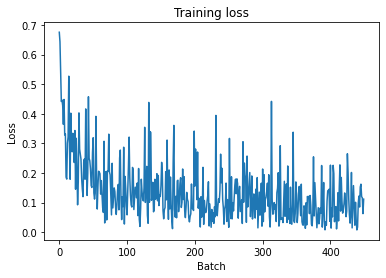

Loss на обучающей выборке: 0.13855
Процент правильных предсказаний на валидационной выборке: 96.62%


In [ ]:

# Будем сохранять loss во время обучения
# и рисовать график в режиме реального времени
train_loss_set = []
train_loss = 0


# Обучение
# Переводим модель в training mode
model.train()

for step, batch in enumerate(train_dataloader):
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    b_input_ids = torch. tensor(b_input_ids). to (torch. int64)
    # если не сделать .zero_grad(), градиенты будут накапливаться
    optimizer.zero_grad()
    
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

    train_loss_set.append(loss[0].item())  
    
    # Backward pass
    loss[0].backward()
    
    # Обновляем параметры и делаем шаг используя посчитанные градиенты
    optimizer.step()

    # Обновляем loss
    train_loss += loss[0].item()
    
    # Рисуем график
    clear_output(True)
    plt.plot(train_loss_set)
    plt.title("Training loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.show()
    
print("Loss на обучающей выборке: {0:.5f}".format(train_loss / len(train_dataloader)))

# Валидация
# Переводим модель в evaluation mode
model.eval()

valid_preds, valid_labels = [], []

for batch in validation_dataloader:   
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    b_input_ids = torch. tensor(b_input_ids). to (torch. int64)
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для валидационных данных.
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.array(label_ids)     
    valid_preds.extend(batch_preds)
    valid_labels.extend(batch_labels)

print('Процент правильных предсказаний на валидационной выборке:', accuracy_score(valid_labels, valid_preds) * 100)

In [ ]:
print('f1_score:', f1_score(valid_labels, valid_preds))

f1_score: 0.81%


In [ ]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in test_sentences]
input_ids = [tokenizer.convert_tokens_to_ids(x[:MAX_LEN]) for x in tokenized_texts]

input_ids = pad_sequences(
    input_ids,
    maxlen=MAX_LEN,
    dtype="long",
    truncating="post",
    padding="post"
)
     

In [ ]:
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(test_gt)

prediction_data = TensorDataset(
    prediction_inputs,
    prediction_masks,
    prediction_labels
)

prediction_dataloader = DataLoader(
    prediction_data, 
    sampler=SequentialSampler(prediction_data),
    batch_size=BATCH_SIZE
)

In [ ]:
start = time.time()

model.eval()
test_preds, test_labels = [], []

for batch in prediction_dataloader:
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    b_input_ids = torch. tensor(b_input_ids). to (torch. int64)
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для тестовых данных.
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Сохраняем предсказанные классы и ground truth
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.array(label_ids)  
    test_preds.extend(batch_preds)
    test_labels.extend(batch_labels)

end = time.time()
time_fit = end - start    

In [ ]:
acc_score = accuracy_score(test_labels, test_preds)
print('Процент правильных предсказаний на отложенной выборке составил: {0:.2f}%'.format(
    acc_score*100
))

Процент правильных предсказаний на отложенной выборке составил: 96.73%


In [ ]:
f1_score(test_labels, test_preds)

0.8236877523553163

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны